# Klusterointi ja assosiaatio

## Tavoitteet
Tavoite tässä prosessissa on optimoida drooneja käyttävän kuljetusyrityksen toimintaa löytämällä optimaalisia sijainteja droonikeskuksille. Yritys haluaa myös suositella asiakkaille tuotteita heidän ostoshistoriansa perusteella, joten datasta halutaan löytää kiinnostavia yhteyksiä eri tuoteryhmien välillä. 

## Datan kuvaus
Käytössä on 2 eri datasettiä: 
- Asiakkaiden sijannit, joka pitää sisällään seuraavat sarakkeet:
- - clientid: Asiakkaan oma tunniste
- - x: Asiakkaan sijainnin x-kordinaatti
- - y: Asiakkaan sijainnin y-kordinaatti
- Tuotteiden myyntidata, joka pitää sisällään seuraavat sarakkeet:
- - ID: Ostotapahtuman tunniste
- - Prod1-Prod20: Binääriarvo, joka kertoo ostettiinko tietystä tuoteryhmästä tuote vai ei arvoilla yksi (1) tai nolla (0).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_cust = pd.read_csv('drone_cust_locations.csv', sep=";", na_values=[""], decimal=".", header=0)
df_prod = pd.read_csv('drone_prod_groups.csv',  sep=";", na_values=[""], decimal=".")

## Osa 1: Klusterointi

Otetaan pieni näyte datasetin sisällöstä. Datasetti ei ole kovin monimutkainen, joten siinä ei pitäisi löytyä paljoa puuttuvia arvoja.

In [3]:
df_cust.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


### Datan visualisointi
Visualisoidaan asiakkaiden sijainnit:
Tämä visualisointi auttaa meitä ymmärtämään asiakkaiden maantieteellistä jakaumaa.

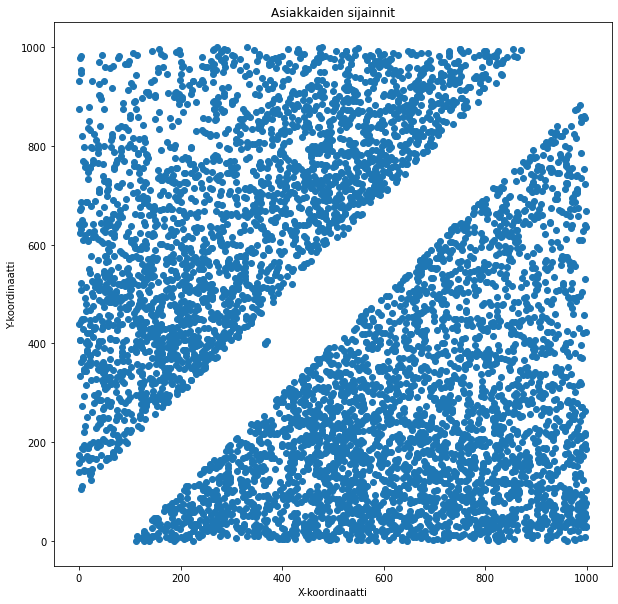

In [4]:
# Create the scatter plot
plt.figure(figsize=(10,10))
plt.scatter(df_cust['x'], df_cust['y'])
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Graafin perusteella voidaan arvioida, että asiakkaiden sijaintien keskeltä menee iso tie tai joki. Seuraavaksi arvioimme kolme optimaalista sijaintia droonikeskuksille.

### Datan esikäsittely
Dataa ei tarvitse tässä vaiheessa normalisoida, koska tutkimme vain kordinaattiarvoja, jotka ovat jo samassa skaalassa. 

In [5]:
df_cust = df_cust.drop(columns="clientid")
df_cust.head()

,x,y
0,622.771572,164.857623
1,416.357298,630.193634
2,292.735020,567.333231
3,737.211288,166.225676
4,540.475375,682.912298


### Mallinnus

In [14]:
from sklearn.cluster import KMeans
n = 3
model_k = KMeans(n_clusters=n, random_state=42)
model_k.fit(df_cust)

KMeans(n_clusters=3, random_state=42)

In [15]:
model_k.cluster_centers_ 

array([[ 1.97952693e+02,  3.84477007e+02,  9.98864926e-01],
       [ 5.48891112e+02,  7.87516069e+02,  1.99824150e+00],
       [ 7.01507220e+02,  2.11240080e+02, -2.44249065e-15]])

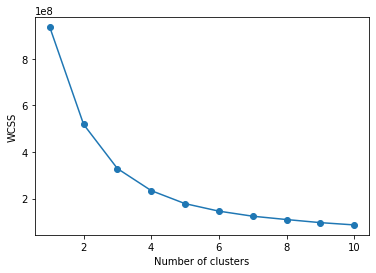

In [16]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df_cust)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Tästä graafista näemme, mikä on optimaalinen määrä klustereita. Tämän datasetin tapauksessa paras määrä näyttää olevan 3, koska 3:n jälkeen WCSS-arvo (within-cluster sum of squared distances) ei laske jyrkästi kuten ennen 3:a.

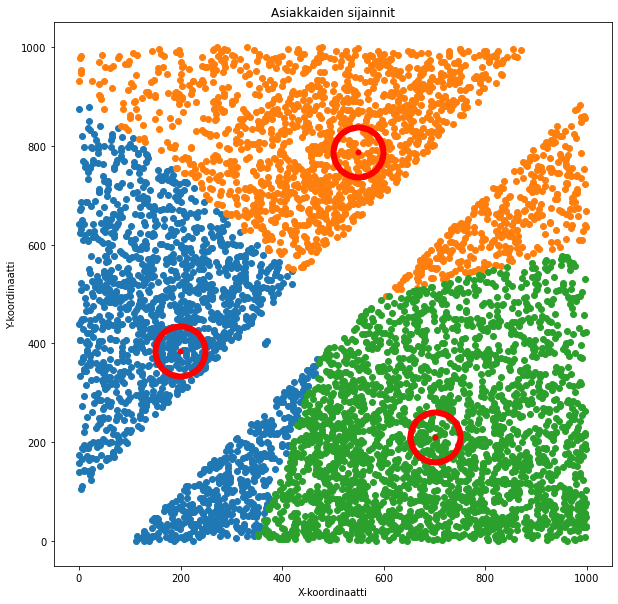

In [17]:
# Create the scatter plot
plt.figure(figsize=(10,10))
for i in range(n):
    plt.scatter(df_cust['x'][model_k.labels_==i], df_cust['y'][model_k.labels_==i])
plt.scatter(model_k.cluster_centers_[:, 0], model_k.cluster_centers_[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Näemme nyt graafista 3:n muodostuneen klusterien keskipisteet. Graafin punaiset pisteet kuvaavat siis droonikeskusten optimaalisia sijainteja. Asiakkaat on myös värikoodattu droonikeskusten mukaan.

Lisätään nyt jokaisen asiakkaan lähin droonikeskus datasettiin.

In [18]:
df_cust_d = df_cust
df_cust_d["d_center"] = model_k.labels_
df_cust_d.head(10)

,x,y,d_center
0,622.771572,164.857623,2
1,416.357298,630.193634,1
2,292.735020,567.333231,0
3,737.211288,166.225676,2
4,540.475375,682.912298,1
5,535.469492,318.439661,2
6,640.380050,870.833221,1
7,235.772075,359.048203,0
8,481.896884,661.491838,1
9,730.032789,312.177817,2


Kokeillaan nyt, minkälaisia tuloksia saamme nostamalla droonikeskusten määrän 10:een.

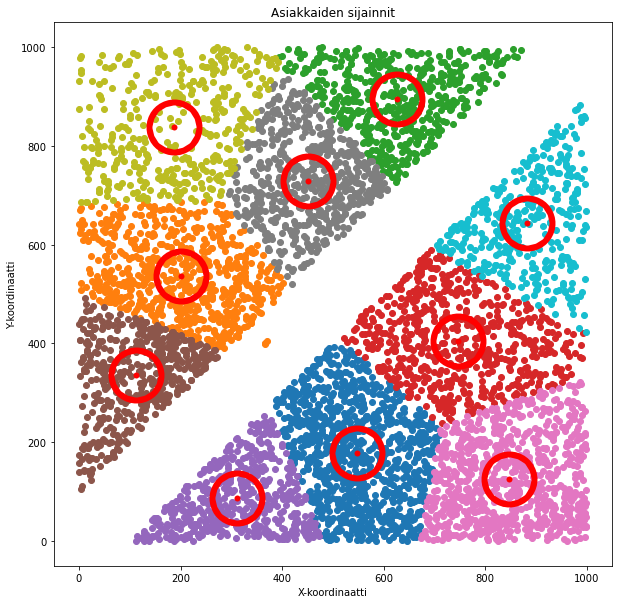

In [24]:
n = 10
model_k = KMeans(n_clusters=n, random_state=42)
model_k.fit(df_cust)

plt.figure(figsize=(10,10))
for i in range(n):
    plt.scatter(df_cust['x'][model_k.labels_==i], df_cust['y'][model_k.labels_==i])
plt.scatter(model_k.cluster_centers_[:, 0], model_k.cluster_centers_[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Graafista löytyy nyt 10 droonikeskusta ja niiden palvelemat asiakkaat. Kun käytettiin arvoa n = 10, mallin ja graafin tekemiseen meni noin kaksinkertainen aika verrattuna n=3 malliin. 

### Arviointi

## Osa 2: Assosiaatio

### Datan ymmärtäminen

### Datan esikäsittely

### Mallinnus

### Arviointi

## Käyttöönotto
Yritys voisi käyttää käsittelystä johdettuja optimaalisia droonikeskuksen sijainteja uusien droonikeskusten sijaintien valintaan. Tuotteiden ostotapahtumien väliset yhteydet voisi suoraan implementoida yrityksen verkkosivuille/sovellukseen antamaan asiakkaille suosituksia, kun hän selailee kauppaa. 